# <center><span style="color:#659BF6">Cyclistic: Bike Share Analysis</span></center>

<center>Author: Timothy Chia </center>

<div style="width:100%;text-align: center;"> <img align=middle src="https://i.imgur.com/RVZQMlT.jpg" alt="Heat beating"> </div>

## <span style="color:#659BF6">1. Summary</span>

Cyclistic is a company that offers bike-sharing services. They own a fleet of 5,824 bicycles that are tracked and locked into a network of 692 stations across Chicago. They offer different pricing plans (i.e. single-ride, full-day, annual membership). Although the pricing flexibility helps Cyclistic attract more customers, the director of marketing, Moreno, believes that maximizing the number of annual members will be key to future growth. 

Finance analysts at Cyclistic have concluded that annual members are much more profitable than casual riders. Rather than creating a marketing campaign that targets all-new customers, Moreno believes there is a very good chance to convert casual riders into members. She notes that casual riders are already aware of the Cyclistic program and have chosen Cyclistic for their mobility needs. 

---

## <span style="color:#659BF6">2. Ask</span>

#### 2.1 Business task

The aim of this case is to analyse differences in consumer behaviour to devise marketing strategies aimed at converting casual riders to members.

To aid in the analysis I will be answering these questions:

1. How do annual members and casual riders use Cyclistic bikes differently? 
2. Why would casual riders buy Cyclistic annual memberships? 
3. How can Cyclistic use digital media to influence casual riders to become members? 

---

## <span style="color:#659BF6">3. Prepare</span>

#### 3.1 Dataset information

The data used in this analysis comes from the [Cyclistic’s historical trip](#https://divvy-tripdata.s3.amazonaws.com/index.html?) dataset. It is made available on their website, and is updated monthly.

#### 3.2 Accessibility and privacy

Bikeshare hereby grants the public a non-exclusive, royalty-free, limited, perpetual license to access, reproduce, analyze, copy, modify, distribute in products or services and use the Data for any lawful purpose. Further details can be found here [here](#https://ride.divvybikes.com/data-license-agreement?).

#### 3.3 Bias and credibility

Cyclistic sets itself apart by offering a variety of bikes, making bike-share more inclusive toward people with disabilities and riders who cannot use a standard two-wheeled bike. Furthermore, the dataset contains observations sampled from a diverse group of users that ride for leisure or commute, eliminating any sampling bias. Hence, it can be concluded that the dataset in unbiased and accurately represents the entire population of Cyclistic users. 

#### 3.4 Does the data ROCCC?

|                      |                                                                                                           |
|----------------------|-----------------------------------------------------------------------------------------------------------|
| <b>R</b>eliability   | Dataset is unbiased, it can be trusted.                                                                   |
| <b>O</b>riginality   | Dataset was obtained internally, hence it is original.                                                    |
| <b>C</b>omprehensive | Dataset contains the necessary information for analysis, no human error observed as dataset was generated.|
| <b>C</b>urrent       | Dataset contains most recent information available from January 2021 to Auguest 2022.                     |
| <b>C</b>ited         | Dataset has been cited by numerous bike-share analysis projects on Kaggle.                                |


#### 3.5 Organisation and verification

The dataset used in this analysis consists of 20 CSV files with a total of 5,595,063 observations, containing ride information for each respective month. I will be focusing on data from 2021 as at the time of this analysis, there is only a full years worth of data for 2021. Also, data is considered wide since the unique identifier `ride_id` does not repeat.

I was able to verify that attributes across all datasets were consistent. There was varying number of observervations (rides) between months, which is to be expected.

#### 3.6 Data limitations

**Missing Demographics**: Since data was made public, Cyclistic has understandably taken steps to anonymise their users data that would otherwise provide an additional level of analysis. Key demographics data such as gender, age, were not identified as such information is under a strict privacy policy.

**Data Collection**: COVID-19 is very much a persistent problem in 2021. While life is slowly returning to normal, commuting habits still do not constitute as 'business-as-usual' scenario.

<!--- #### 3.7 Statistical constraints

 https://www.surveymonkey.com/mp/sample-size-calculator/ 

Confidence level: 95%

Margin of error: 5%

Population size: -

Sample size: - -->

#### 3.7 Importing necessary packages

In [1]:
import os
import glob
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from tqdm import tqdm
!pip install calplot
from calplot import calplot
from folium import plugins, Marker
from datetime import date, datetime
from folium.plugins import HeatMapWithTime, MarkerCluster

start_time = time()

#### 3.8 Importing & concatenating datasets

In [2]:
files_2021 = glob.glob("../input/cyclistic-dataset/Cyclistic Data/2021/*.csv")

data = [pd.read_csv(f) for f in files_2021]
rides_df = pd.concat(data, ignore_index=True, axis=0)

#### 3.9 Dataset preview

In [3]:
rides_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,620BC6107255BF4C,electric_bike,2021-10-22 12:46:42,2021-10-22 12:49:50,Kingsbury St & Kinzie St,KA1503000043,NaN,NaN,41.889186,-87.638495,41.89,-87.63,member
1,4471C70731AB2E45,electric_bike,2021-10-21 09:12:37,2021-10-21 09:14:14,NaN,NaN,NaN,NaN,41.930000,-87.700000,41.93,-87.71,member
2,26CA69D43D15EE14,electric_bike,2021-10-16 16:28:39,2021-10-16 16:36:26,NaN,NaN,NaN,NaN,41.920000,-87.700000,41.94,-87.72,member
3,362947F0437E1514,electric_bike,2021-10-16 16:17:48,2021-10-16 16:19:03,NaN,NaN,NaN,NaN,41.920000,-87.690000,41.92,-87.69,member
4,BB731DE2F2EC51C5,electric_bike,2021-10-20 23:17:54,2021-10-20 23:26:10,NaN,NaN,NaN,NaN,41.890000,-87.710000,41.89,-87.69,member


---

## <span style="color:#659BF6">4. Process</span>

### 4.1 Dataset summary

In [4]:
rides_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5595063 entries, 0 to 5595062
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             5595063 non-null  object 
 1   rideable_type       5595063 non-null  object 
 2   started_at          5595063 non-null  object 
 3   ended_at            5595063 non-null  object 
 4   start_station_name  4904254 non-null  object 
 5   start_station_id    4904257 non-null  object 
 6   end_station_name    4855893 non-null  object 
 7   end_station_id      4855893 non-null  object 
 8   start_lat           5595063 non-null  float64
 9   start_lng           5595063 non-null  float64
 10  end_lat             5590292 non-null  float64
 11  end_lng             5590292 non-null  float64
 12  member_casual       5595063 non-null  object 
dtypes: float64(4), object(9)
memory usage: 554.9+ MB


##### 4.1.1 Checking unique values in dataset

In [5]:
rides_df.nunique()

ride_id               5595063
rideable_type               3
started_at            4677998
ended_at              4671372
start_station_name        847
start_station_id          834
end_station_name          844
end_station_id            832
start_lat              394205
start_lng              374003
end_lat                445033
end_lng                405226
member_casual               2
dtype: int64

##### 4.1.2 Checking for duplicates

In [6]:
print(f'Number of duplicate rows: {rides_df.duplicated().sum()}')

Number of duplicate rows: 0


### 4.2 Investigating missingness

In [7]:
null_count = rides_df.isna().sum()
null_percent = round((rides_df.isna().sum() / len(rides_df)) * 100, 3)

nullity = pd.DataFrame({
    'null_count' :  null_count,
    'null_percent' : null_percent
}, index=null_count.index).sort_values(
    by=['null_count', 'null_percent'], ascending=False)

nullity.style.background_gradient(axis=1, low=.75, high=1.)

,null_count,null_percent
end_station_name,739170,13.211000
end_station_id,739170,13.211000
start_station_name,690809,12.347000
start_station_id,690806,12.347000
end_lat,4771,0.085000
end_lng,4771,0.085000
ride_id,0,0.000000
rideable_type,0,0.000000
started_at,0,0.000000
ended_at,0,0.000000


##### 4.2.1 Missingness correlation

Although the propensity for missingness in `start_station_name` and `start_station_id` appear highly correlated and systematic, this has to do with other variables related to each ride. 

Similar behaviour can be observed with `end_station_name`, `end_station_id`, `end_lat` and `end_lng` as well. Hence, these variables would be considered missing at random (MAR).

With that said, missingness within these fields can roughly be interpolated from the remaining values to a reasonable degree of accuracy. 

However, since the focus of the analysis will be on the users riding behaviour, `start_station_name`, `start_station_id`, `end_station_name`, and `end_station_id` will be dropped.

In [8]:
null_corr = rides_df.isna().corr()
null_corr.style.background_gradient(axis=None, low=.75, high=1.)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
ride_id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rideable_type,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
started_at,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ended_at,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
start_station_name,nan,nan,nan,nan,1.000000,0.999998,0.532612,0.532612,nan,nan,-0.010964,-0.010964,nan
start_station_id,nan,nan,nan,nan,0.999998,1.000000,0.532611,0.532611,nan,nan,-0.010964,-0.010964,nan
end_station_name,nan,nan,nan,nan,0.532612,0.532611,1.000000,1.000000,nan,nan,0.074877,0.074877,nan
end_station_id,nan,nan,nan,nan,0.532612,0.532611,1.000000,1.000000,nan,nan,0.074877,0.074877,nan
start_lat,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
start_lng,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### 4.3 Data cleansing

<!-- We will begin the data cleaning and transformation process. This involves:

- Identifying and removing duplicates and nulls
- Formatting datatypes
- Renaming columns
- Sorting -->

##### 4.3.1 Dropping columns and rows

In [9]:
rides_df.drop(['start_station_name', 'start_station_id', 
                'end_station_name', 'end_station_id'], axis=1, inplace=True)

rides_df.dropna(subset=['end_lat', 'end_lng'], how='all', inplace=True) # Dropping of rows here is arguable as it may bias the dataset with only rides that end up returned

##### 4.3.2 Renaming columns

In [10]:
rides_df.rename(columns={
    'rideable_type' : 'bike_type', 
    'member_casual' : 'member'
}, inplace=True)

##### 4.3.3 Transforming `member` column

In [11]:
rides_df['member'] = rides_df['member'].apply(lambda x: True if x == 'member' else False)

##### 4.3.4 Assigning appropriate data types

In [12]:
rides_df['started_at'] = pd.to_datetime(rides_df['started_at'])
rides_df['ended_at'] = pd.to_datetime(rides_df['ended_at'])

### 4.4 Transforming columns

In [13]:
# new attributes for each timestamp component
rides_df['day_of_year'] = tqdm(rides_df['started_at'].dt.day_of_year)
rides_df['day_of_week'] = tqdm(rides_df['started_at'].dt.dayofweek)
rides_df['month'] = tqdm(rides_df['started_at'].dt.month)
rides_df['hour'] = tqdm(rides_df['started_at'].dt.hour)
rides_df['minute'] = tqdm(rides_df['started_at'].dt.minute)
rides_df['ride_duration (min)'] = tqdm((rides_df['ended_at'] - rides_df['started_at']).apply(
    lambda x: x.total_seconds() / 60
))

100%|██████████| 5590292/5590292 [00:01<00:00, 2798315.73it/s]


##### 4.4.1 Creating distance column

In [14]:
from math import radians, cos, sin, asin, sqrt

# credit: https://stackoverflow.com/a/4913653
def haversine(start_lng, start_lat, end_lng, end_lat):
    '''
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    '''
    # convert decimal degrees to radians 
    start_lng, start_lat, end_lng, end_lat = map(radians, [start_lng, start_lat, end_lng, end_lat])
    # haversine formula 
    dlon = end_lng - start_lng 
    dlat = end_lat - start_lat 
    a = sin(dlat/2)**2 + cos(start_lat) * cos(end_lat) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

start_coords = rides_df[['start_lat', 'start_lng']]
end_coords = rides_df[['end_lat', 'end_lng']]

distances = []

for idx in tqdm(range(len(rides_df))):
    start_lat, start_lng = start_coords.iloc[idx].values
    end_lat, end_lng = end_coords.iloc[idx].values

    result = haversine(start_lng=start_lng, start_lat=start_lat,
                       end_lng=end_lng, end_lat=end_lat)
    distances.append(result)

rides_df['ride_distance (km)'] = distances

100%|██████████| 5590292/5590292 [13:30<00:00, 6896.39it/s]


### 4.5 Verifying data integrity

In [15]:
print(f'Dataset shape: {rides_df.shape}')
print(f'Number of null values: {rides_df.isna().sum().sum()}')
print(f'Number of duplicate rows: {rides_df.duplicated().sum()}')
print(f'Number of unique values:\n\n{rides_df.nunique()}')

Dataset shape: (5590292, 16)
Number of null values: 0
Number of duplicate rows: 0
Number of unique values:

ride_id                5590292
bike_type                    3
started_at             4674512
ended_at               4667802
start_lat               394205
start_lng               374003
end_lat                 445033
end_lng                 405226
member                       2
day_of_year                365
day_of_week                  7
month                       12
hour                        24
minute                      60
ride_duration (min)      24960
ride_distance (km)     1690807
dtype: int64


##### 4.5.1 Numerical Summary

In [16]:
print('\033[1m' + 'Numerical summary:' + '\033[0m')
rides_df.describe().T

Numerical summary:


,count,mean,std,min,25%,50%,75%,max
start_lat,5590292.0,41.901084,0.046071,41.640000,41.881619,41.898969,41.929143,42.070000
start_lng,5590292.0,-87.646050,0.028717,-87.840000,-87.660000,-87.641823,-87.627734,-87.520000
end_lat,5590292.0,41.901341,0.046189,41.390000,41.881840,41.899643,41.929199,42.168116
end_lng,5590292.0,-87.646258,0.028900,-88.970000,-87.660000,-87.642746,-87.627754,-87.490000
day_of_year,5590292.0,209.716594,75.847991,1.000000,158.000000,213.000000,267.000000,365.000000
day_of_week,5590292.0,3.182165,1.998293,0.000000,1.000000,3.000000,5.000000,6.000000
month,5590292.0,7.418624,2.492191,1.000000,6.000000,8.000000,9.000000,12.000000
hour,5590292.0,14.242063,5.051371,0.000000,11.000000,15.000000,18.000000,23.000000
minute,5590292.0,29.475876,17.293306,0.000000,14.000000,29.000000,44.000000,59.000000
ride_duration (min),5590292.0,20.981170,167.660085,-58.033333,6.733333,11.983333,21.733333,55944.150000


##### 4.5.2 Handling outliers

In [17]:
# I will set an acceptable range of ride_minutes between 1-720 minutes.
drop_filter = (rides_df['ride_duration (min)'] < 1) | (
    rides_df['ride_duration (min)'] > 720)
outlier_percent = round((len(rides_df[drop_filter]) / len(rides_df)) * 100, 3)

rides_df.drop(rides_df.index[drop_filter], inplace=True)

display(rides_df['ride_duration (min)'].describe().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
ride_duration (min),5500839.0,19.148743,26.440897,1.0,6.95,12.166667,21.933333,719.883333


### 4.6 Save cleaned dataset

In [18]:
# rearrange columns
rides_df = rides_df[['ride_id', 'bike_type', 'started_at', 'ended_at', 'day_of_year', 'day_of_week', 'month', 'hour', 'minute', 
                     'start_lat', 'start_lng', 'end_lat', 'end_lng', 'ride_duration (min)', 'ride_distance (km)', 'member']]
today = date.today().strftime('%d%m%Y')

try:
    current_version = (max(
        [int(f[-5:-4]) if f else 1 for f in glob.glob("../working/Cleaned Data/*.csv")]))
except ValueError:
    current_version = 1

# save dataset as CSV
dir_exist = os.path.exists(path='../working/Cleaned Data')
file_exist = os.path.exists(
    path=f'../working/Cleaned Data/Cyclistic_{today}_v{current_version}.csv')

if not dir_exist:
    os.makedirs('../working/Cleaned Data')

if file_exist:
    current_version += 1
    
with open(f'../working/Cleaned Data/Cyclistic_{today}_v{current_version}.csv', 'w') as f:
    rides_df.to_csv(f, index=False)

---

## <span style="color:#659BF6">5. Analyse</span>



In [19]:
rides_df = pd.read_csv(
    f'../working/Cleaned Data/Cyclistic_{today}_v{current_version}.csv')
rides_df['started_at'] = pd.to_datetime(rides_df['started_at'])
rides_df['ended_at'] = pd.to_datetime(rides_df['ended_at'])

casual_subset = rides_df[rides_df['member'] == False]
member_subset = rides_df[rides_df['member'] == True]

### 5.1 Ridership Overview

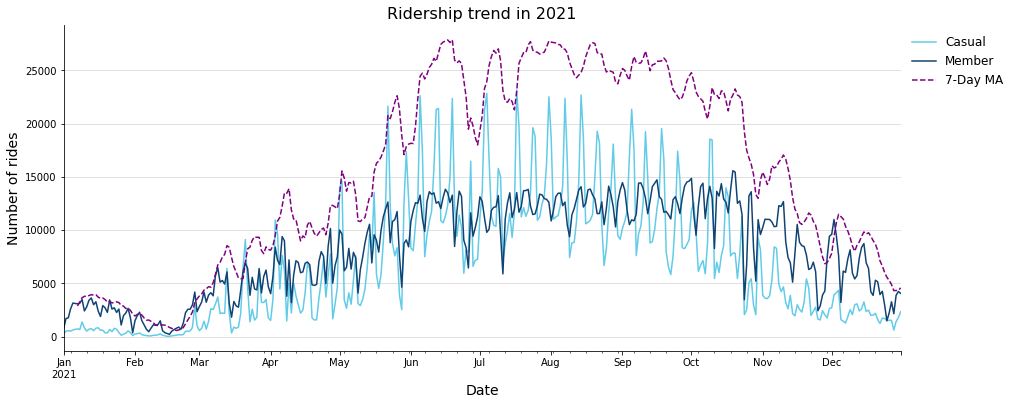

In [20]:
date_range = pd.date_range(start=min(rides_df['started_at'].dt.date), end=max(
    rides_df['started_at'].dt.date), freq='D')
time_series = pd.DataFrame({
    'Casual': casual_subset['ride_id'].groupby(casual_subset['started_at'].dt.date).count(),
    'Member': member_subset['ride_id'].groupby(member_subset['started_at'].dt.date).count()
}, index=date_range)
time_series['7-Day MA'] = (time_series['Casual'] +
                           time_series['Member']).rolling(7).mean()

plt.figure(figsize=(15, 6))
time_series['Casual'].plot(color='#62CBE7', label='Casual')
time_series['Member'].plot(color='#104373', label='Member')
time_series['7-Day MA'].plot(color='purple', linestyle='--', label='7-Day MA')

plt.title('Ridership trend in 2021', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of rides', fontsize=14)

sns.despine(left=False, bottom=False)
plt.legend(loc='upper left', fontsize=12, frameon=False, bbox_to_anchor=(1, 1))
plt.grid(axis='y', color='grey', alpha=.3)
plt.show()

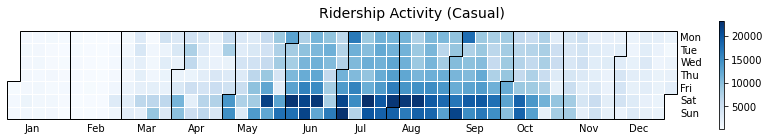

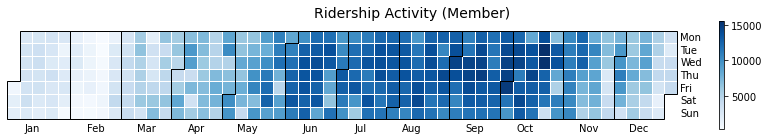

In [21]:
casual_ridership = pd.Series(casual_subset[['day_of_year', 'ride_id']].groupby(
    'day_of_year')['ride_id'].count().values, index=date_range)
member_ridership = pd.Series(member_subset[['day_of_year', 'ride_id']].groupby(
    'day_of_year')['ride_id'].count().values, index=date_range)

cp1 = calplot(casual_ridership, edgecolor='k', cmap='Blues', yearlabels=False, suptitle='Ridership Activity (Casual)',
              suptitle_kws={'fontsize': 14}, tight_layout=False, figsize=(15, 2))
cp2 = calplot(member_ridership, edgecolor='k', cmap='Blues', yearlabels=False, suptitle='Ridership Activity (Member)',
              suptitle_kws={'fontsize': 14}, tight_layout=False, figsize=(15, 2))

plt.show()

### 5.2 Understanding bike usage

,classic_bike,electric_bike,docked_bike
Casual,1249000,931107,307553
Member,1953914,1059264,1


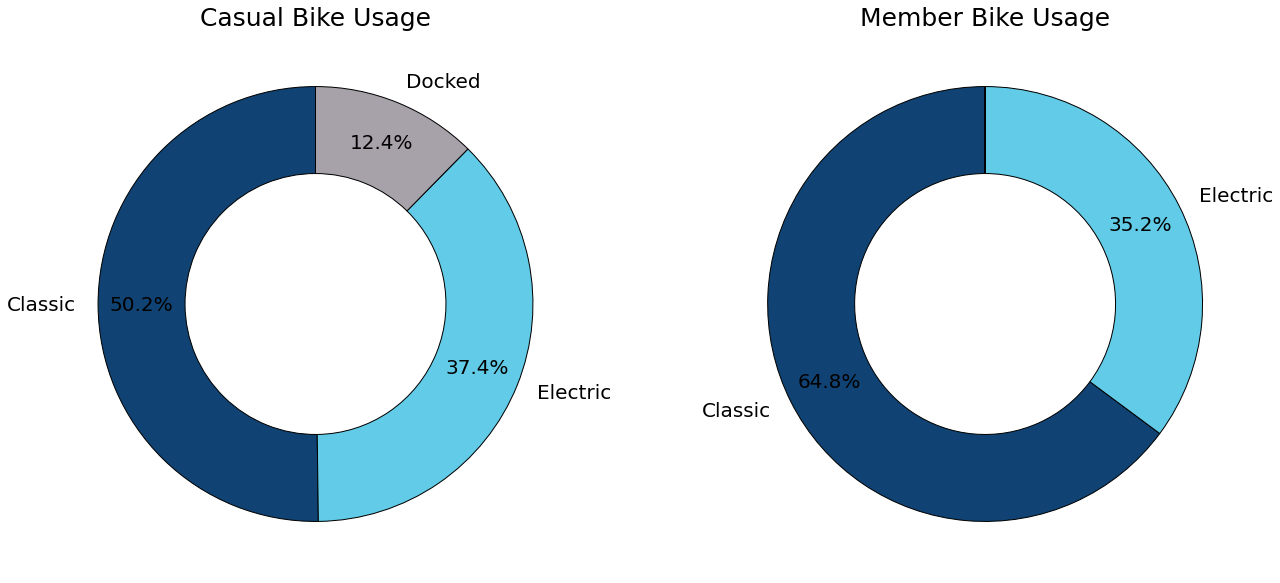

In [22]:
casual_bike_pref = casual_subset['bike_type'].value_counts()
member_bike_pref = member_subset['bike_type'].value_counts()

display(pd.DataFrame({
    'Casual': casual_bike_pref,
    'Member': member_bike_pref
}).T)

size = .4
colors = ['#104373', '#62CBE7', '#A7A2A9']
labels = ['Classic', 'Electric', 'Docked']

f, ax = plt.subplots(1, 2, figsize=(22, 10))
plt.rcParams['font.size'] = 20
ax[0].pie(casual_bike_pref, colors=colors, labels=labels, autopct='%.1f%%', pctdistance=.8, labeldistance=1.1,
          startangle=90, radius=1, wedgeprops=dict(width=size, edgecolor='k'))
wedges, texts, autotexts = ax[1].pie(member_bike_pref, colors=colors, labels=labels, autopct='%.1f%%', pctdistance=.8, labeldistance=1.1,
                                     startangle=90, radius=1, wedgeprops=dict(width=size, edgecolor='k'))

ax[0].set_title('Casual Bike Usage', fontsize=25)
ax[1].set_title('Member Bike Usage', fontsize=25)

threshold = 20
for label, pct_label in zip(texts, autotexts):
    pct_value = pct_label.get_text().rstrip('%')
    if float(pct_value) < threshold:
        label.set_text('')
        pct_label.set_text('')

plt.show()

**<u>Observations</u>**

- The pie chart above shows the proportions of bike types used in rides during 2021 by both casual and member users.

- It appears that the classic bikes are the most favoured among both casual and member users as their usage constituted more than 50% of all rides in 2021. 

- Electric bikes take up >30% of rides in both groups making it the second most used bike type behind classic bikes.

- It can also be seen that both user groups did not use docked bikes as much as classic or electric bikes. The use of docked bikes only made up 12.4% of rides in the casual group , while close to no member users rode them in 2021.

### 5.3 Understanding monthly rides

Total ridership per month:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Casual,17780,9847,82810,134431,252416,363788,434816,406553,358415,253142,105125,68537
Member,77468,38490,142295,197358,269740,352433,373649,385250,385735,367337,248594,174830


Ridership percent change:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Casual,nan,-44.620000,740.970000,62.340000,87.770000,44.120000,19.520000,-6.500000,-11.840000,-29.370000,-58.470000,-34.800000
Member,nan,-50.310000,269.690000,38.700000,36.680000,30.660000,6.020000,3.100000,0.130000,-4.770000,-32.330000,-29.670000


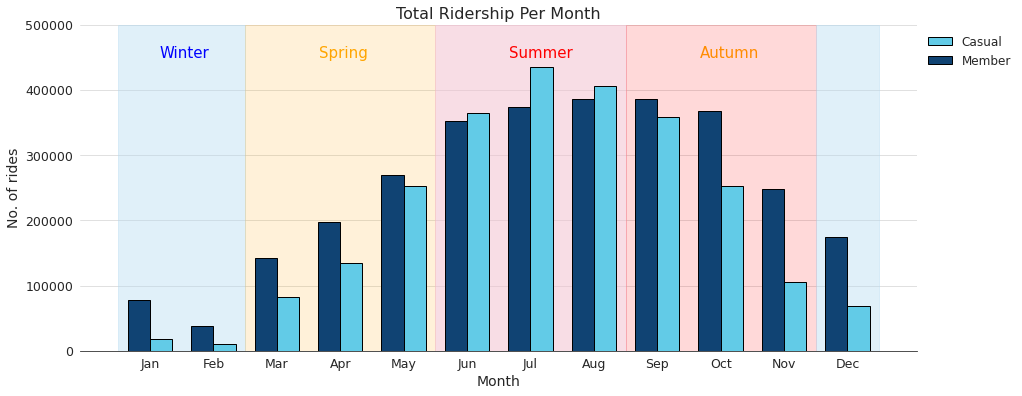

In [23]:
# total rides per month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May',
               'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_ridership_casual = casual_subset.groupby(
    'month')['ride_id'].count().values
monthly_ridership_member = member_subset.groupby(
    'month')['ride_id'].count().values

print('\033[1m' + 'Total ridership per month:' + '\033[0m')
display(pd.DataFrame({
    'Casual': monthly_ridership_casual,
    'Member': monthly_ridership_member
}, index=month_names).T.style.background_gradient(axis=1, low=.75, high=1.))

# ridership percent change
casual_percent_change = (casual_subset.groupby(
    'month')['ride_id'].count().pct_change().values * 100).round(2)
member_percent_change = (member_subset.groupby(
    'month')['ride_id'].count().pct_change().values * 100).round(2)

print('\033[1m' + 'Ridership percent change:' + '\033[0m')
display(pd.DataFrame({
    'Casual': casual_percent_change,
    'Member': member_percent_change
}, index=month_names).T.style.background_gradient(axis=1, low=.75, high=1.))

width = .35
edge_color = 'k'
alignment = 'edge'

sns.set_style('white')
plt.figure(figsize=(15, 6))
plt.rcParams['font.size'] = 12.5

plt.axvspan(-.5, 1.5, alpha=.4, color='#B3DAF1')  # winter
plt.axvspan(1.5, 4.5, alpha=.15, color='orange')  # spring
plt.axvspan(4.5, 7.5, alpha=.5, color='#F2BDCD')  # summer
plt.axvspan(7.5, 10.5, alpha=.15, color='r')  # autumn
plt.axvspan(10.5, 11.5, alpha=.4, color='#B3DAF1')  # winter

plt.text(.15, 450000, 'Winter', fontsize=15, color='b')
plt.text(2.67, 450000, 'Spring', fontsize=15, color='orange')
plt.text(5.67, 450000, 'Summer', fontsize=15, color='r')
plt.text(8.67, 450000, 'Autumn', fontsize=15, color='darkorange')

plt.bar(x=month_names, height=monthly_ridership_casual, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual')
plt.bar(x=month_names, height=monthly_ridership_member, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member')

plt.title('Total Ridership Per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('No. of rides', fontsize=14)
plt.ylim(0, 500000)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper left', fontsize=12, frameon=False, bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=False)

plt.show()

**<u>Observations</u>**

- The bar chart above shows the total monthly ridership for both user groups.

- A general decrease in ridership can be seen in the following months after spring period, with ridership of casual and annual members peaking between summer and autumn periods. The data appears to show that weather/seasonality and ridership share a causal relationship. 

- It is also interesting to note that percentage change in ridership of casual riders significantly decrease during autumn and winter periods as compared to members.


<!-- spring - march, april, may
summer - june, july, august
autumn - september, october, november
winter - december, january, february -->

Average ride duration per month:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Casual,19.945921,26.699968,29.778924,29.700712,30.395943,28.468949,27.018529,25.782191,24.652538,22.275736,18.134760,17.572179
Member,12.332685,14.691703,13.829087,14.488287,14.500489,14.438448,14.148888,13.964392,13.563806,12.320615,11.033081,10.857799


Average ride duration percent change:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Casual,nan,33.860000,11.530000,-0.260000,2.340000,-6.340000,-5.090000,-4.580000,-4.380000,-9.640000,-18.590000,-3.100000
Member,nan,19.130000,-5.870000,4.770000,0.080000,-0.430000,-2.010000,-1.300000,-2.870000,-9.170000,-10.450000,-1.590000


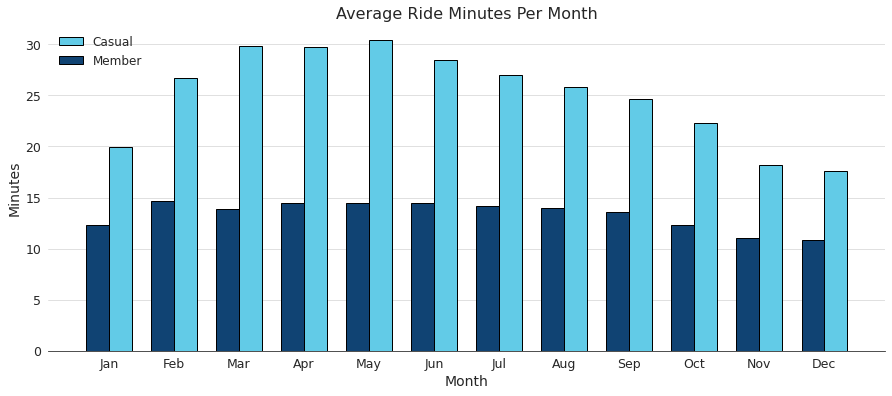

In [24]:
# avg ride minutes per month
avg_monthly_minutes_casual = casual_subset.groupby(
    'month')['ride_duration (min)'].mean().values
avg_monthly_minutes_member = member_subset.groupby(
    'month')['ride_duration (min)'].mean().values

print('\033[1m' + 'Average ride duration per month:' + '\033[0m')
display(pd.DataFrame({
    'Casual': avg_monthly_minutes_casual,
    'Member': avg_monthly_minutes_member
}, index=month_names).T.style.background_gradient(axis=1, low=.75, high=1.))

# avg ride minutes percent change
casual_percent_change = (casual_subset.groupby(
    'month')['ride_duration (min)'].mean().pct_change().values * 100).round(2)
member_percent_change = (member_subset.groupby(
    'month')['ride_duration (min)'].mean().pct_change().values * 100).round(2)

print('\033[1m' + 'Average ride duration percent change:' + '\033[0m')
display(pd.DataFrame({
    'Casual': casual_percent_change,
    'Member': member_percent_change
}, index=month_names).T.style.background_gradient(axis=1, low=.75, high=1.))

plt.figure(figsize=(15, 6))
plt.bar(x=month_names, height=avg_monthly_minutes_casual, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual')
plt.bar(x=month_names, height=avg_monthly_minutes_member, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member')

plt.title('Average Ride Minutes Per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Minutes', fontsize=14)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper left', fontsize=12, frameon=False)
sns.despine(left=True, bottom=False)
plt.show()

**<u>Observations</u>**

- The bar plot above shows the average ride minutes per month.

- It is evident that casual riders end up riding for a much longer duration during warmer seasons with up to a 33.86% increase for casual riders and only 19.13% increase for annual members.

- A significant decrease in ridership for both groups can also be seen with a 18.59% decrease for casual riders and 10.45% decrease for annual members.

- The average ride minutes for annual members appear fairly consistent ranging from 10-15 minutes, alluding that transport commutes are unchanged for those that choose to continue riding during the colder months.

Average ride distance per month:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Casual,2.004628,2.078525,2.109274,2.119024,2.205882,2.296007,2.335972,2.369942,2.397506,2.307842,2.127064,2.043270
Member,1.958119,2.006489,2.156689,2.195454,2.235894,2.279686,2.289882,2.252499,2.216358,2.052544,1.900558,1.908712


Average ride distance percent change:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Casual,nan,3.690000,1.480000,0.460000,4.100000,4.090000,1.740000,1.450000,1.160000,-3.740000,-7.830000,-3.940000
Member,nan,2.470000,7.490000,1.800000,1.840000,1.960000,0.450000,-1.630000,-1.600000,-7.390000,-7.400000,0.430000


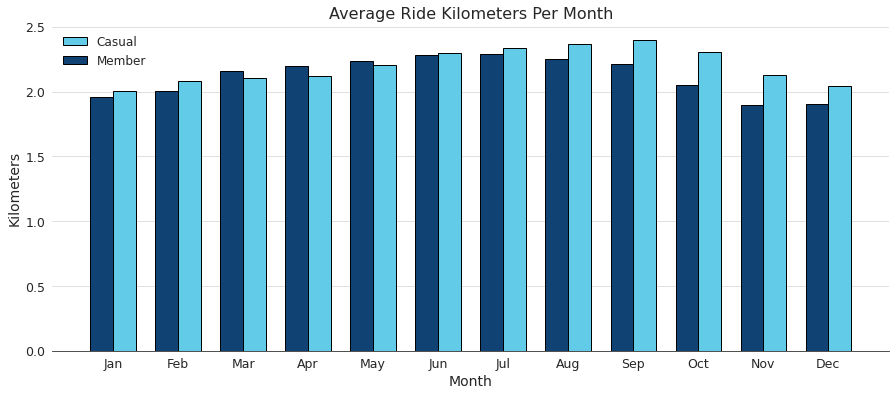

In [25]:
# avg ride kilmeters per month
avg_monthly_km_casual = casual_subset.groupby(
    'month')['ride_distance (km)'].mean().values
avg_monthly_km_member = member_subset.groupby(
    'month')['ride_distance (km)'].mean().values

print('\033[1m' + 'Average ride distance per month:' + '\033[0m')
display(pd.DataFrame({
    'Casual': avg_monthly_km_casual,
    'Member': avg_monthly_km_member
}, index=month_names).T.style.background_gradient(axis=1, low=.75, high=1.))

# percent change om average rode kilometers per month
casual_percent_change = (casual_subset.groupby(
    'month')['ride_distance (km)'].mean().pct_change().values * 100).round(2)
member_percent_change = (member_subset.groupby(
    'month')['ride_distance (km)'].mean().pct_change().values * 100).round(2)

print('\033[1m' + 'Average ride distance percent change:' + '\033[0m')
display(pd.DataFrame({
    'Casual': casual_percent_change,
    'Member': member_percent_change
}, index=month_names).T.style.background_gradient(axis=1, low=.75, high=1.))

plt.figure(figsize=(15, 6))
plt.bar(x=month_names, height=avg_monthly_km_casual, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual')
plt.bar(x=month_names, height=avg_monthly_km_member, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member')

plt.title('Average Ride Kilometers Per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Kilometers', fontsize=14)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper left', fontsize=12, frameon=False)
sns.despine(left=True, bottom=False)
plt.show()

**<u>Observations</u>**

- Generally, there is an increase in distance travelled for each ride. Casual riders can be seen travelling for much greater distances throughout summer, autumn and winter seasons as compared to annual members which only see an increase in travel distance during spring.

- It is interesting to note that casual riders travel longer distances during warmer seasons and annual members travel longer distances regardless of seasons or temperature.

### 5.4 Understanding daily rides

Total rides per day:


,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Casual,281739,269980,274529,281540,358077,548796,472999
Member,409089,457928,469382,444208,438719,424891,368962


Total rides percent change:


,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Casual,nan,-4.170000,1.680000,2.550000,27.190000,53.260000,-13.810000
Member,nan,11.940000,2.500000,-5.360000,-1.240000,-3.150000,-13.160000


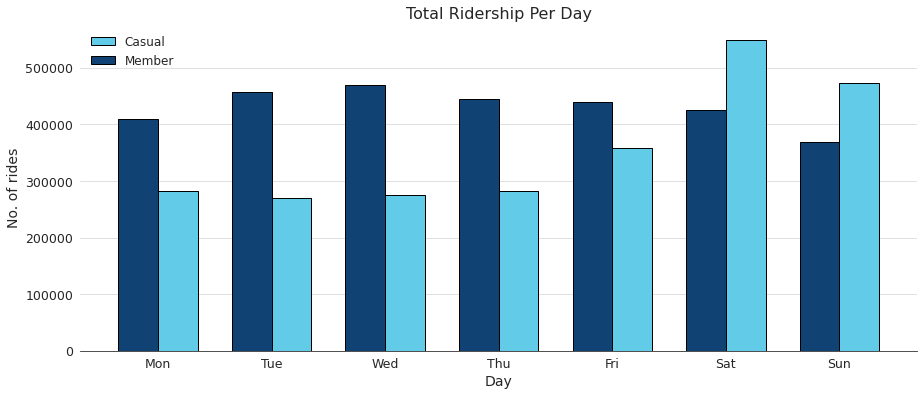

In [26]:
# total rides per day
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_ridership_casual = casual_subset.groupby(
    'day_of_week')['ride_id'].count().values
daily_ridership_member = member_subset.groupby(
    'day_of_week')['ride_id'].count().values

print('\033[1m' + 'Total rides per day:' + '\033[0m')
display(pd.DataFrame({
    'Casual': daily_ridership_casual,
    'Member': daily_ridership_member
}, index=day_names).T.style.background_gradient(axis=1, low=.75, high=1.))

# percent change in total rides per day
casual_percent_change = (casual_subset.groupby('day_of_week')[
                         'ride_id'].count().pct_change().values * 100).round(2)
member_percent_change = (member_subset.groupby('day_of_week')[
                         'ride_id'].count().pct_change().values * 100).round(2)

print('\033[1m' + 'Total rides percent change:' + '\033[0m')
display(pd.DataFrame({
    'Casual': casual_percent_change,
    'Member': member_percent_change
}, index=day_names).T.style.background_gradient(axis=1, low=.75, high=1.))

plt.figure(figsize=(15, 6))
plt.bar(x=day_names, height=daily_ridership_casual, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual')
plt.bar(x=day_names, height=daily_ridership_member, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member')

plt.title('Total Ridership Per Day', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('No. of rides', fontsize=14)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper left', fontsize=12, frameon=False)
sns.despine(left=True, bottom=False)
plt.show()

**<u>Observations</u>**

- The bar charts above show the total ridership per day in 2021.

- We can see that annual members ride a significant amount more than casual users during weekdays with up to an 11.94% increase, while casual users ridership are the highest closer to the weekends with up an increase ranging from 25% to 55%.

- This could be due to annual members using the bikes to commute to and from school/work, while on the other hand casual users may use these bikes for leisure activities during the weekends.

Average ride minutes per day:


,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Casual,26.538173,23.643590,22.701446,22.362071,24.116946,28.344233,30.320751
Member,12.953154,12.636894,12.681168,12.583634,13.099512,15.006917,15.346392


Average ride minutes percent change:


,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Casual,nan,-10.910000,-3.980000,-1.490000,7.850000,17.530000,6.970000
Member,nan,-2.440000,0.350000,-0.770000,4.100000,14.560000,2.260000


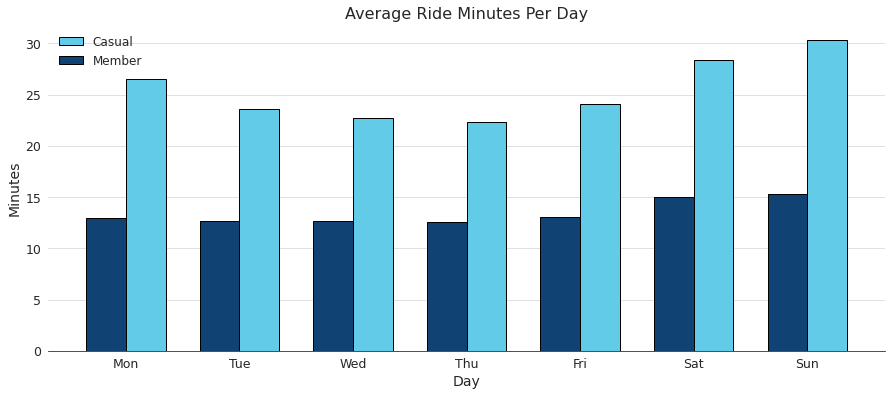

In [27]:
# avg ride minutes per day
avg_daily_minutes_casual = casual_subset.groupby(
    'day_of_week')['ride_duration (min)'].mean().values
avg_daily_minutes_member = member_subset.groupby(
    'day_of_week')['ride_duration (min)'].mean().values

print('\033[1m' + 'Average ride minutes per day:' + '\033[0m')
display(pd.DataFrame({
    'Casual': avg_daily_minutes_casual,
    'Member': avg_daily_minutes_member
}, index=day_names).T.style.background_gradient(axis=1, low=.75, high=1.))

# percent change in average ride minutes per day
casual_percent_change = (casual_subset.groupby('day_of_week')[
                         'ride_duration (min)'].mean().pct_change().values * 100).round(2)
member_percent_change = (member_subset.groupby('day_of_week')[
                         'ride_duration (min)'].mean().pct_change().values * 100).round(2)

print('\033[1m' + 'Average ride minutes percent change:' + '\033[0m')
display(pd.DataFrame({
    'Casual': casual_percent_change,
    'Member': member_percent_change
}, index=day_names).T.style.background_gradient(axis=1, low=.75, high=1.))

plt.figure(figsize=(15, 6))
plt.bar(x=day_names, height=avg_daily_minutes_casual, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual')
plt.bar(x=day_names, height=avg_daily_minutes_member, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member')

plt.title('Average Ride Minutes Per Day', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Minutes', fontsize=14)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper left', fontsize=12, frameon=False)
sns.despine(left=True, bottom=False)
plt.show()

**<u>Observations</u>**

- The bar charts above show the average ride duration (in minutes) per day in 2021.

- From comparing the average ride durations of casual riders and annual member, we can see that on average casual users ride for longer durations with the longest travel duration of >30 minutes on Sundays, while annual members ride for a somewhat consistent amount of time. 

- Both groups have see a significant increase in ride duration closer to the weekends, with Saturdays having the highest increase of 17.53% of casual riders and 4.56% for annual members.

Average ride kilometers per day:


,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Casual,2.186092,2.214792,2.238097,2.249203,2.277823,2.377211,2.351646
Member,2.108823,2.121010,2.134375,2.116131,2.130523,2.273512,2.270152


Average ride kilometers percent change:


,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Casual,nan,1.310000,1.050000,0.500000,1.270000,4.360000,-1.080000
Member,nan,0.580000,0.630000,-0.850000,0.680000,6.710000,-0.150000


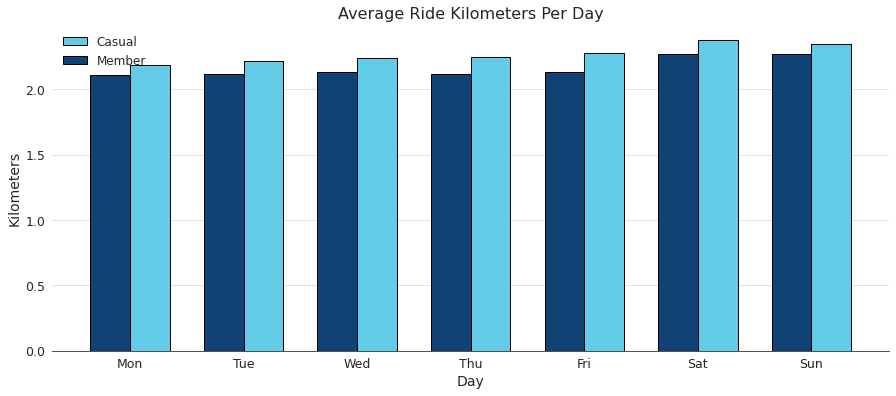

In [28]:
# avg ride kilmeters per day
avg_daily_km_casual = casual_subset.groupby(
    'day_of_week')['ride_distance (km)'].mean().values
avg_daily_km_member = member_subset.groupby(
    'day_of_week')['ride_distance (km)'].mean().values

print('\033[1m' + 'Average ride kilometers per day:' + '\033[0m')
display(pd.DataFrame({
    'Casual': avg_daily_km_casual,
    'Member': avg_daily_km_member
}, index=day_names).T.style.background_gradient(axis=1, low=.75, high=1.))

# percent change in average ride kilometers per day
casual_percent_change = (casual_subset.groupby('day_of_week')[
                         'ride_distance (km)'].mean().pct_change().values * 100).round(2)
member_percent_change = (member_subset.groupby('day_of_week')[
                         'ride_distance (km)'].mean().pct_change().values * 100).round(2)

print('\033[1m' + 'Average ride kilometers percent change:' + '\033[0m')
display(pd.DataFrame({
    'Casual': casual_percent_change,
    'Member': member_percent_change
}, index=day_names).T.style.background_gradient(axis=1, low=.75, high=1.))

plt.figure(figsize=(15, 6))
plt.bar(x=day_names, height=avg_daily_km_casual, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual')
plt.bar(x=day_names, height=avg_daily_km_member, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member')

plt.title('Average Ride Kilometers Per Day', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Kilometers', fontsize=14)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper left', fontsize=12, frameon=False)
sns.despine(left=True, bottom=False)
plt.show()

**<u>Observations</u>**

- The bar chart above shows the average ride distance (in kilometers) per day in 2021.

- From the bar chart, while both groups travel at distances >2km, casual riders appear to travel longer distances than members throughout the week. Both groups see an increase in travel distance closer to the weekend with the highest increase in distance being 4.36% for casual riders and 4.67% for annual members on Saturdays.

### 5.5 Understanding hourly rides

Hourly Casual Ridership (Weekdays):


,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Casual Weekday,21092,12743,7667,4849,4836,8225,19753,36661,45002,42545,51110,65675,80423,85073,89330,99843,120836,158696,146272,111787,80132,67812,61179,44324
Member Weekday,14537,7573,4021,2701,5180,25866,72120,132662,145875,91453,77191,94632,114790,111791,108948,135281,192865,257730,215851,149639,99122,71803,53032,34663


Hourly Casual Ridership Percent Change (Weekdays):


,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Casual,nan,-39.580000,-39.830000,-36.750000,-0.270000,70.080000,140.160000,85.600000,22.750000,-5.460000,20.130000,28.500000,22.460000,5.780000,5.000000,11.770000,21.030000,31.330000,-7.830000,-23.580000,-28.320000,-15.370000,-9.780000,-27.550000
Member,nan,-47.910000,-46.900000,-32.830000,91.780000,399.340000,178.820000,83.950000,9.960000,-37.310000,-15.590000,22.590000,21.300000,-2.610000,-2.540000,24.170000,42.570000,33.630000,-16.250000,-30.670000,-33.760000,-27.560000,-26.140000,-34.640000


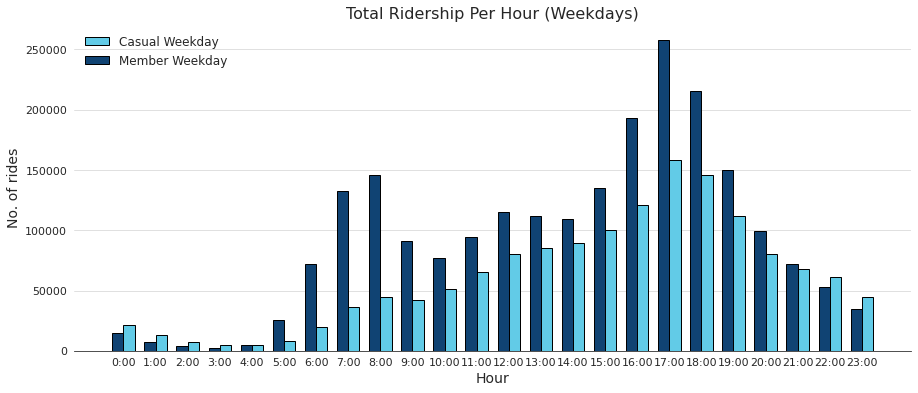

Hourly Member Ridership: (Weekends)


,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Casual Weekend,31749,25681,17326,8918,4897,4091,5607,9438,17692,32520,52015,68194,79058,85619,86307,85748,81281,74244,64064,51697,39804,34133,33312,28400
Member Weekend,17920,13837,8142,4309,2817,3711,8490,14900,24720,37263,49838,58069,62752,62914,62556,62240,60320,57164,50967,41266,30002,23568,20127,15961


Hourly Casual Ridership Percent Change (Weekends):


,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Casual,nan,-19.110000,-32.530000,-48.530000,-45.090000,-16.460000,37.060000,68.330000,87.450000,83.810000,59.950000,31.100000,15.930000,8.300000,0.800000,-0.650000,-5.210000,-8.660000,-13.710000,-19.300000,-23.010000,-14.250000,-2.410000,-14.750000
Member,nan,-22.780000,-41.160000,-47.080000,-34.630000,31.740000,128.780000,75.500000,65.910000,50.740000,33.750000,16.520000,8.060000,0.260000,-0.570000,-0.510000,-3.080000,-5.230000,-10.840000,-19.030000,-27.300000,-21.450000,-14.600000,-20.700000


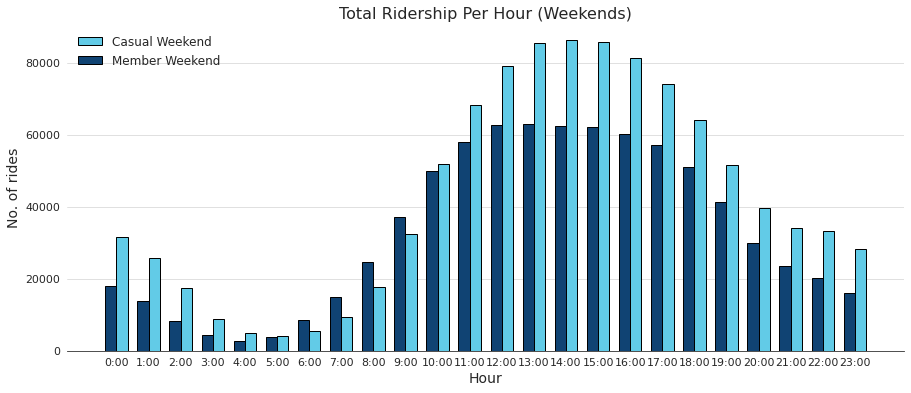

In [29]:
# total rides per hour (weekday vs weekend)
hours = [f'{i}:00' for i in range(0, 24)]

hourly_ridership_casual_weekday = casual_subset[casual_subset['day_of_week'].isin(
    range(0, 5))].groupby('hour')['ride_id'].count().values
hourly_ridership_member_weekday = member_subset[member_subset['day_of_week'].isin(
    range(0, 5))].groupby('hour')['ride_id'].count().values

hourly_ridership_casual_weekend = casual_subset[casual_subset['day_of_week'].isin(
    range(5, 7))].groupby('hour')['ride_id'].count().values
hourly_ridership_member_weekend = member_subset[member_subset['day_of_week'].isin(
    range(5, 7))].groupby('hour')['ride_id'].count().values

print('\033[1m' + 'Hourly Casual Ridership (Weekdays):' + '\033[0m')
display(pd.DataFrame({
    'Casual Weekday': hourly_ridership_casual_weekday,
    'Member Weekday': hourly_ridership_member_weekday
}, index=hours).T.style.background_gradient(axis=1, low=.75, high=1.))

# percent change in total rides per hour (weekdays)
casual_percent_change = (casual_subset[casual_subset['day_of_week'].isin(
    range(0, 5))].groupby('hour')['ride_id'].count().pct_change().values * 100).round(2)
member_percent_change = (member_subset[member_subset['day_of_week'].isin(
    range(0, 5))].groupby('hour')['ride_id'].count().pct_change().values * 100).round(2)

print('\033[1m' + 'Hourly Casual Ridership Percent Change (Weekdays):' + '\033[0m')
display(pd.DataFrame({
    'Casual': casual_percent_change,
    'Member': member_percent_change
}, index=hours).T.style.background_gradient(axis=1, low=.75, high=1.))

plt.figure(figsize=(15, 6))
plt.rcParams['font.size'] = 11
plt.bar(x=hours, height=hourly_ridership_casual_weekday, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual Weekday')
plt.bar(x=hours, height=hourly_ridership_member_weekday, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member Weekday')

plt.title('Total Ridership Per Hour (Weekdays)', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('No. of rides', fontsize=14)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper left', fontsize=12, frameon=False)
sns.despine(left=True, bottom=False)
plt.show()

print('\033[1m' + 'Hourly Member Ridership: (Weekends)' + '\033[0m')
display(pd.DataFrame({
    'Casual Weekend': hourly_ridership_casual_weekend,
    'Member Weekend': hourly_ridership_member_weekend
}, index=hours).T.style.background_gradient(axis=1, low=.75, high=1.))

# percent change in total rides per hour (weekends)
casual_percent_change = (casual_subset[casual_subset['day_of_week'].isin(
    range(5, 7))].groupby('hour')['ride_id'].count().pct_change().values * 100).round(2)
member_percent_change = (member_subset[member_subset['day_of_week'].isin(
    range(5, 7))].groupby('hour')['ride_id'].count().pct_change().values * 100).round(2)

print('\033[1m' + 'Hourly Casual Ridership Percent Change (Weekends):' + '\033[0m')
display(pd.DataFrame({
    'Casual': casual_percent_change,
    'Member': member_percent_change
}, index=hours).T.style.background_gradient(axis=1, low=.75, high=1.))

plt.figure(figsize=(15, 6))
plt.bar(x=hours, height=hourly_ridership_casual_weekend, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual Weekend')
plt.bar(x=hours, height=hourly_ridership_member_weekend, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member Weekend')

plt.title('Total Ridership Per Hour (Weekends)', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('No. of rides', fontsize=14)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper left', fontsize=12, frameon=False)
sns.despine(left=True, bottom=False)
plt.show()

**<u>Observations</u>**

- The bar charts above show the total ridership per hour on weekdays and weekends in 2021.

- We can see that throughout the day <u>**on weekdays**</u>, there is a gradual increase in ridership for casual riders from 3am onwards with ridership peaking at 4pm-6pm period. On the other hand, we see two peak periods of travel during the day for members with 7am-9am being the first period and 4pm-6pm being the second period.  

- <u>**Weekend**</u> ridership on the other hand, shows an increase and decrease in activity during peak periods for both groups as one would expect. Ridership is at its lowest from 4am and gradually increase with ridership peaking during the 1pm-3pm periods. It is also worth mentioning that although there is a gradual decrease, casual users travel more during the afternoon to midnight periods (12pm-12am)

Average Ride Minutes Per Hour (Weekdays):


,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Casual Weekday,25.321038,26.503820,25.378236,24.306369,19.836528,16.771250,15.064201,15.889324,17.959366,23.350479,28.135812,28.830714,27.226717,28.233573,27.493702,25.995336,24.293276,22.570306,22.043270,22.347979,22.900843,22.368205,22.052059,22.755666
Member Weekday,12.337352,13.338741,13.232301,13.595816,11.836544,10.963326,11.869516,12.058240,11.849726,11.832806,12.423537,12.514547,12.070806,12.166830,12.774618,12.984085,13.360725,13.656075,13.492698,13.287032,13.129614,12.874203,12.974294,12.837924


Percent Change in Average Ride Minutes Per Hour (Weekdays):


,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Casual Weekday,8.980000,14.070000,9.230000,4.610000,-14.620000,-27.820000,-35.160000,-31.610000,-22.700000,0.500000,21.090000,24.090000,17.180000,21.520000,18.330000,11.880000,4.560000,-2.860000,-5.130000,-3.820000,-1.440000,-3.730000,-5.090000,-2.060000
Member Weekday,-2.430000,5.490000,4.650000,7.530000,-6.390000,-13.290000,-6.130000,-4.630000,-6.280000,-6.420000,-1.750000,-1.030000,-4.540000,-3.780000,1.030000,2.690000,5.670000,8.000000,6.710000,5.080000,3.840000,1.820000,2.610000,1.530000


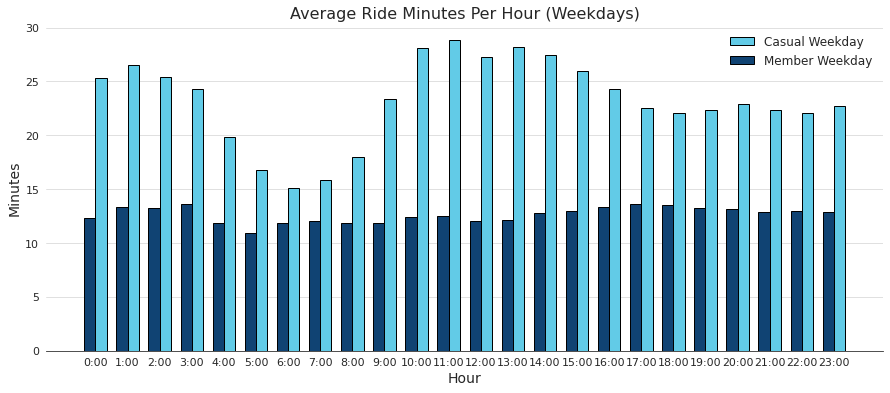

Average Ride Minutes Per Hour (Weekends):


,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Casual Weekend,24.186289,23.589251,24.694117,25.883853,24.911527,24.578359,26.428774,28.249689,28.978129,30.220845,31.104580,31.876686,31.927012,32.317790,32.153862,30.832529,29.628632,28.559703,27.102332,27.074843,27.024126,26.646444,25.667020,25.533621
Member Weekend,13.653061,13.974656,13.924042,14.121973,14.492474,15.379938,14.848011,14.372638,13.982497,14.391458,14.861565,15.342314,15.633992,16.082179,16.210357,15.898939,15.815195,15.542277,14.976671,14.633818,14.347712,14.189299,14.145787,13.721001


Percent Change in Average Ride Minutes Per Hour (Weekends):


,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Casual Weekend,-13.260000,-15.400000,-11.430000,-7.170000,-10.650000,-11.850000,-5.210000,1.320000,3.930000,8.390000,11.560000,14.330000,14.510000,15.910000,15.320000,10.580000,6.260000,2.430000,-2.800000,-2.900000,-3.080000,-4.430000,-7.940000,-8.420000
Member Weekend,-7.580000,-5.400000,-5.740000,-4.400000,-1.900000,4.110000,0.510000,-2.710000,-5.350000,-2.580000,0.600000,3.860000,5.830000,8.870000,9.730000,7.620000,7.060000,5.210000,1.380000,-0.940000,-2.880000,-3.950000,-4.240000,-7.120000


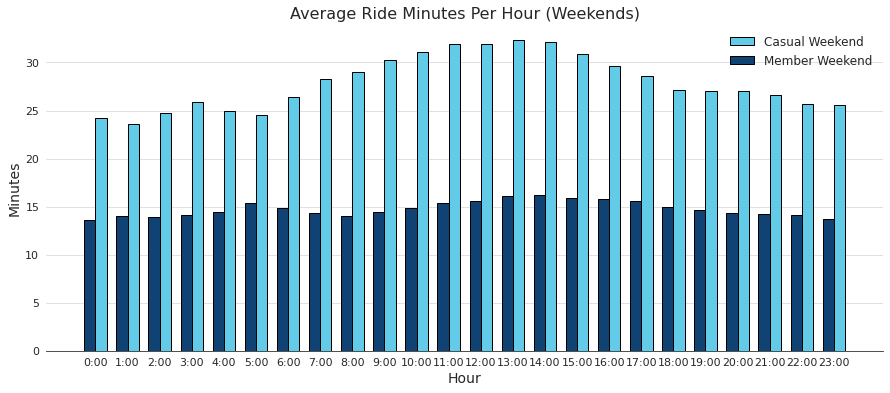

In [30]:
# avg ride minutes per hour (weekday vs weekend)
avg_hourly_minutes_casual_weekday = casual_subset[casual_subset['day_of_week'].isin(
    range(0, 5))].groupby('hour')['ride_duration (min)'].mean().values
avg_hourly_minutes_member_weekday = member_subset[member_subset['day_of_week'].isin(
    range(0, 5))].groupby('hour')['ride_duration (min)'].mean().values

avg_hourly_minutes_casual_weekend = casual_subset[casual_subset['day_of_week'].isin(
    range(5, 7))].groupby('hour')['ride_duration (min)'].mean().values
avg_hourly_minutes_member_weekend = member_subset[member_subset['day_of_week'].isin(
    range(5, 7))].groupby('hour')['ride_duration (min)'].mean().values

print('\033[1m' + 'Average Ride Minutes Per Hour (Weekdays):' + '\033[0m')
display(pd.DataFrame({
    'Casual Weekday': avg_hourly_minutes_casual_weekday,
    'Member Weekday': avg_hourly_minutes_member_weekday
}, index=hours).T.style.background_gradient(axis=1, low=.75, high=1.))

# percent change in avg ride minutes per hour (weekdays)
percent_change_avg_hourly_minutes_casual_weekday = (
    (avg_hourly_minutes_casual_weekday - avg_hourly_minutes_casual_weekday.mean()) / avg_hourly_minutes_casual_weekday.mean() * 100).round(2)
percent_change_avg_hourly_minutes_member_weekday = (
    (avg_hourly_minutes_member_weekday - avg_hourly_minutes_member_weekday.mean()) / avg_hourly_minutes_member_weekday.mean() * 100).round(2)

print('\033[1m' + 'Percent Change in Average Ride Minutes Per Hour (Weekdays):' + '\033[0m')
display(pd.DataFrame({
    'Casual Weekday': percent_change_avg_hourly_minutes_casual_weekday,
    'Member Weekday': percent_change_avg_hourly_minutes_member_weekday
}, index=hours).T.style.background_gradient(axis=1, low=.75, high=1.))

plt.figure(figsize=(15, 6))
plt.bar(x=hours, height=avg_hourly_minutes_casual_weekday, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual Weekday')
plt.bar(x=hours, height=avg_hourly_minutes_member_weekday, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member Weekday')

plt.title('Average Ride Minutes Per Hour (Weekdays)', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Minutes', fontsize=14)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper right', fontsize=12, frameon=False)
sns.despine(left=True, bottom=False)
plt.show()

print('\033[1m' + 'Average Ride Minutes Per Hour (Weekends):' + '\033[0m')
display(pd.DataFrame({
    'Casual Weekend': avg_hourly_minutes_casual_weekend,
    'Member Weekend': avg_hourly_minutes_member_weekend
}, index=hours).T.style.background_gradient(axis=1, low=.75, high=1.))

# percent change in avg ride minutes per hour (weekends)
percent_change_avg_hourly_minutes_casual_weekend = (
    (avg_hourly_minutes_casual_weekend - avg_hourly_minutes_casual_weekend.mean()) / avg_hourly_minutes_casual_weekend.mean() * 100).round(2)
percent_change_avg_hourly_minutes_member_weekend = (
    (avg_hourly_minutes_member_weekend - avg_hourly_minutes_member_weekend.mean()) / avg_hourly_minutes_member_weekend.mean() * 100).round(2)

print('\033[1m' + 'Percent Change in Average Ride Minutes Per Hour (Weekends):' + '\033[0m')
display(pd.DataFrame({
    'Casual Weekend': percent_change_avg_hourly_minutes_casual_weekend,
    'Member Weekend': percent_change_avg_hourly_minutes_member_weekend
}, index=hours).T.style.background_gradient(axis=1, low=.75, high=1.))

plt.figure(figsize=(15, 6))
plt.bar(x=hours, height=avg_hourly_minutes_casual_weekend, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual Weekend')
plt.bar(x=hours, height=avg_hourly_minutes_member_weekend, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member Weekend')

plt.title('Average Ride Minutes Per Hour (Weekends)', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Minutes', fontsize=14)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper right', fontsize=12, frameon=False)
sns.despine(left=True, bottom=False)
plt.show()

**<u>Observations</u>**

- The bar chart above shows the average ride duration (in minutes) per hour on weekdays and weekends in 2021.

- Members appear to travel a consistent duration with trips lasting around 10-15 minutes on both weekdays and weekends. 

- This is different for casual riders however, as their trips appear to last varying durations throught the day. On weekdays, casual riders travel for longer durations during 12am-2am in the morning and 10am-1pm in the afternoon. And during the weekends, ride times gradually increase after 5am and peaking at 1pm where rides would last >30minutes. 

Average Ride Kilometers Per Hour (Weekdays):


,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Casual Weekday,2.043288,2.090357,2.196852,2.345456,2.447573,2.360574,2.249576,2.309370,2.274045,2.241696,2.230592,2.246583,2.202401,2.230675,2.242879,2.293187,2.320767,2.372152,2.258980,2.134147,2.077738,2.117850,2.175172,2.128019
Member Weekday,2.064537,2.013581,2.106183,2.053285,2.479731,2.346949,2.315667,2.297883,2.179291,2.032018,1.978505,1.908832,1.825212,1.902271,2.037221,2.126025,2.247703,2.258993,2.153883,2.071712,2.059419,2.107981,2.177104,2.175520


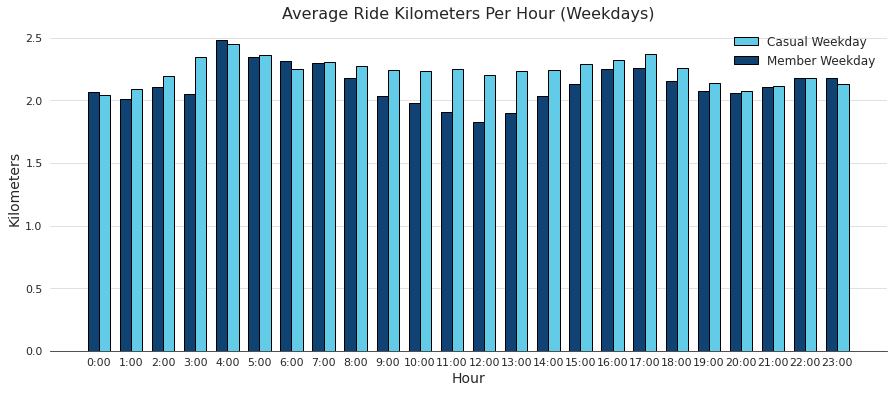

Average Ride Kilometers Per Hour (Weekends):


,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Casual Weekend,2.168703,2.238107,2.344211,2.359647,2.489228,2.537120,2.409072,2.431846,2.375028,2.442504,2.494701,2.548576,2.557827,2.531616,2.469836,2.422923,2.420309,2.355249,2.234442,2.121391,2.029114,2.004492,2.108401,2.154241
Member Weekend,2.223079,2.176916,2.189243,2.209250,2.469395,2.773791,2.552115,2.409814,2.277246,2.294317,2.280665,2.314431,2.321762,2.350869,2.358828,2.329981,2.300797,2.250354,2.169618,2.093759,2.047376,2.117578,2.210464,2.206585


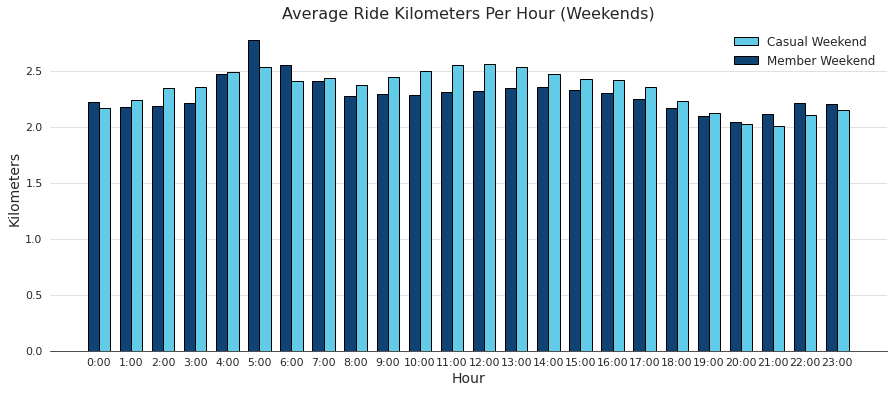

In [31]:
# avg ride kilometers per hour
avg_hourly_kilometers_casual_weekday = casual_subset[casual_subset['day_of_week'].isin(
    range(0, 5))].groupby('hour')['ride_distance (km)'].mean().values
avg_hourly_kilometers_member_weekday = member_subset[member_subset['day_of_week'].isin(
    range(0, 5))].groupby('hour')['ride_distance (km)'].mean().values

avg_hourly_kilometers_casual_weekend = casual_subset[casual_subset['day_of_week'].isin(
    range(5, 7))].groupby('hour')['ride_distance (km)'].mean().values
avg_hourly_kilometers_member_weekend = member_subset[member_subset['day_of_week'].isin(
    range(5, 7))].groupby('hour')['ride_distance (km)'].mean().values

print('\033[1m' + 'Average Ride Kilometers Per Hour (Weekdays):' + '\033[0m')
display(pd.DataFrame({
    'Casual Weekday': avg_hourly_kilometers_casual_weekday,
    'Member Weekday': avg_hourly_kilometers_member_weekday
}, index=hours).T.style.background_gradient(axis=1, low=.75, high=1.))

plt.figure(figsize=(15, 6))
plt.bar(x=hours, height=avg_hourly_kilometers_casual_weekday, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual Weekday')
plt.bar(x=hours, height=avg_hourly_kilometers_member_weekday, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member Weekday')

plt.title('Average Ride Kilometers Per Hour (Weekdays)', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Kilometers', fontsize=14)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper right', fontsize=12, frameon=False)
sns.despine(left=True, bottom=False)
plt.show()

print('\033[1m' + 'Average Ride Kilometers Per Hour (Weekends):' + '\033[0m')
display(pd.DataFrame({
    'Casual Weekend': avg_hourly_kilometers_casual_weekend,
    'Member Weekend': avg_hourly_kilometers_member_weekend
}, index=hours).T.style.background_gradient(axis=1, low=.75, high=1.))

plt.figure(figsize=(15, 6))
plt.bar(x=hours, height=avg_hourly_kilometers_casual_weekend, width=width,
        align=alignment, edgecolor=edge_color, color='#62CBE7', label='Casual Weekend')
plt.bar(x=hours, height=avg_hourly_kilometers_member_weekend, width=-width,
        align=alignment, edgecolor=edge_color, color='#104373', label='Member Weekend')

plt.title('Average Ride Kilometers Per Hour (Weekends)', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Kilometers', fontsize=14)

plt.grid(axis='y', color='grey', alpha=.3)
plt.legend(loc='upper right', fontsize=12, frameon=False)
sns.despine(left=True, bottom=False)
plt.show()

**<u>Observations</u>**

- The bar chart above shows the average travel distance (in kilometers) per hour on weekdays and weekends.

- During weekdays, both groups appear to have two peak timings, of which rides cover the 
most distance. These are 4am-5am in the morning and 4pm-5pm in the afternoon. It can also be seen that travel distances are at its lowest during lunch hours of 11am-1pm.

- During weekends, we can see that causual riders reach peak distances of >2.5km at 5am and 11am-1pm. As for members, they reach peak distances around the 4am-6am ranges.

### Geographical Analysis - WIP

In [32]:
end = time() - start_time
print('Time taken: {:.2f} seconds'.format(end))

Time taken: 1153.78 seconds


---

## <span style="color:#659BF6">6. Act - WIP</span>

<!-- ### 6.1 Recommendations

#### 1) Weekend Promotions

#### 2) Seasonal Promotions

#### 3) Loyalty Program

#### 4) 

#### 5)  -->